<img src="https://www.netlanguages.com/blog/wp-content/uploads/2017/04/tomatoes.jpg">

<h1><center>English Accent Recognition</center></h1>


### Intro 🌍

There are over 160 different dialects English language all around the world.

The aim in this project is to predict the English accent of the speaker from the recording of their speech.
I propose some preprocessing approaches to classify different English accents using Mozilla’s open source Common Voice dataset.
This notebook is the Exploratory Data Analysis part and I'll go through an exploration of the meta-data an then perform some in-depth analysis of the audio, including visualizations.

---

Thanks for inspiration go to [Andrada Olteanu](https://www.kaggle.com/andradaolteanu) with her wonderful Kaggle notebooks: 

[Birdcall Recognition: EDA and Audio FE](https://www.kaggle.com/andradaolteanu/birdcall-recognition-eda-and-audio-fe) and
[Work w/ Audio Data: Visualise, Classify, Recommend](https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend)

### Imports and Config

In [184]:
import os

import pandas as pd
import numpy as np

import sklearn

# Audio processing
from pydub import AudioSegment
from pydub.silence import detect_leading_silence
import librosa
import librosa.display as lbd
import IPython.display as ipd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import warnings
warnings.filterwarnings('ignore')

In [185]:
# Dataset Pathways
DATA_PATH = 'dataset/'
SAMPLES_PATH = 'samples/'

ACCENTS_CSV = 'source_df.h5'

## Mozilla’s Common Voice dataset

### Data Overview

500 hours of speech recordings, with speaker demographics

**The corpus is split into several parts:**
- The subsets with “valid” in their name are audio clips that have had at least 2 people listen to them, and the majority of those listeners say the audio matches the text.
- The subsets with “invalid” in their name are clips that have had at least 2 listeners, and the majority say the audio does *not* match the clip.
- All other clips, ie. those with fewer than 2 votes, or those that have equal valid and invalid votes, have “other” in their name.

**The “valid” and “other” subsets are further divided into 3 groups:**
- dev - for development and experimentation
- train - for use in speech recognition training
- test - for testing word error rate

---

<div class="alert alert-block alert-info">
💡 <b>Data Preparation</b> has been performed for all the meta-info delivered with the dataset (initially in the <code>.tsv</code> format) which resulted in a single pandas dataframe, saved in <code>hdf5</code> file format.
</div>


#### DataFrame Table Structure:

`source_df.h5` contains information about the validated audio files which have certain 'accent' label. There are **319257** datapoints in **8** unique columns.


**Each row of a dataframe represents a single audio clip, and contains the following:**

* `filename` - relative path of the audio file
* `text` - supposed transcription of the audio
* `up_votes` - number of people who said audio matches the text
* `down_votes` - number of people who said audio does not match text
* `age` - age of the speaker, if the speaker reported it
* `gender` - gender of the speaker, if the speaker reported it
* `accent` - accent of the speaker, if the speaker reported it


**Age details:**
* `teens`: < 19
* `twenties`: 19 - 29
* `thirties`: 30 - 39
* `fourties`: 40 - 49
* `fifties`: 50 - 59
* `sixties`: 60 - 69
* `seventies`: 70 - 79
* `eighties`: 80 - 89
* `nineties`: > 89

**Gender details:**
* `male`
* `female`
* `other`

**Accent details:**
* `us`: 'United States English'
* `england`: 'England English'
* `indian`: 'India and South Asia (India, Pakistan, Sri Lanka)'
* `australia`: 'Australian English'
* `canada`: 'Canadian English'
* `scotland`: 'Scottish English'
* `ireland`: 'Irish English'
* `newzealand`: 'New Zealand English'
* `african`: 'Southern African (South Africa, Zimbabwe, Namibia)'
* `philippines`: 'Filipino'
* `singapore`: 'Singaporean English'
* `hongkong`: 'Hong Kong English'

In [186]:
# Load data
df = pd.read_hdf(DATA_PATH + ACCENTS_CSV)

df.head()

client_id                          path  \
24   id_5830   common_voice_en_1027059.mp3   
72   id_5849  common_voice_en_21788001.mp3   
73   id_5849  common_voice_en_21788002.mp3   
74   id_5849  common_voice_en_21788003.mp3   
75   id_5849  common_voice_en_21788004.mp3   

                                             sentence  up_votes  down_votes  \
24                  Little things please little minds         2           0   
72  Unfortunately, Adam overloads the computer, fr...         2           0   
73  Nepal Loktantrik Primary School is one of the ...         2           0   
74  In the same article, Gardner denied that he co...         2           0   
75  During her literary career, she has written po...         2           1   

         age gender accent  votes_disparity_rate  
24  twenties   male     us              0.398656  
72  thirties   male     us              0.398656  
73  thirties   male     us              0.398656  
74  thirties   male     us              0.398656  
75  thirties   male     us              0.087053

## General Exploration

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319257 entries, 24 to 16134
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             319257 non-null  object 
 1   path                  319257 non-null  object 
 2   sentence              319257 non-null  object 
 3   up_votes              319257 non-null  int64  
 4   down_votes            319257 non-null  int64  
 5   age                   313977 non-null  object 
 6   gender                314496 non-null  object 
 7   accent                319257 non-null  object 
 8   votes_disparity_rate  319257 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 24.4+ MB


In [188]:
df.nunique()

client_id                 7160
path                    319257
sentence                319257
up_votes                    16
down_votes                   7
age                          9
gender                       3
accent                      12
votes_disparity_rate        46
dtype: int64

- 7160 unique speakers
- Each spoken sentence is unique
- 9 types of age
- 3 types of gender
- 12 unique English accents

In [189]:
print(f'The {df.accent.nunique()} unique English accents in the dataset are:')
df['accent'].value_counts()

The 12 unique English accents in the dataset are:


us             171217
england         46836
indian          33637
australia       24230
canada          21077
scotland         6204
ireland          3938
newzealand       3378
african          3188
philippines      2295
singapore        2001
hongkong         1256
Name: accent, dtype: int64

Now let's move on to a more detailed exploration of the features.
We'll view the features, visualize distribution and listen to random audio examples of each attribute

#### Accent

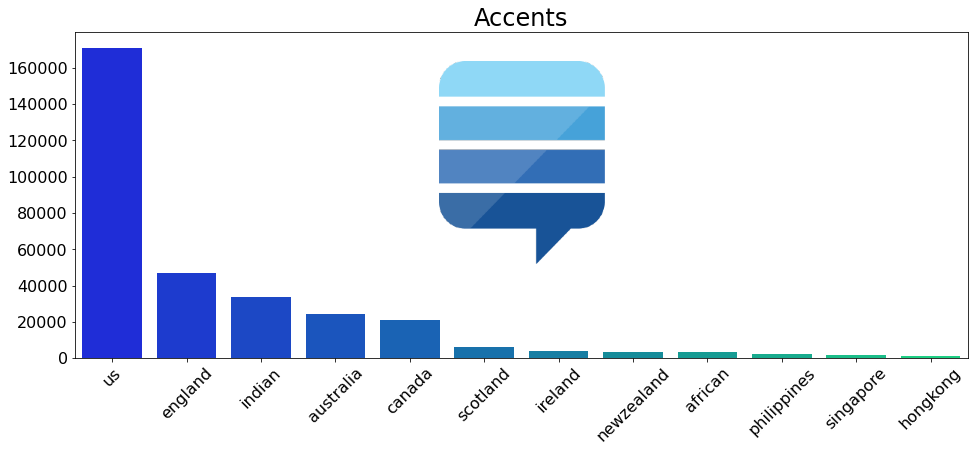

In [190]:
img_accents = mpimg.imread('https://cdn.sstatic.net\
/Sites/stackexchange/Img/apple-touch-icon@2.png')
imagebox = OffsetImage(img_accents, zoom=0.75)
ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), 
                    frameon=False, pad=1, xybox=(5.5, 110000))

plt.figure(figsize=(16, 6))
ax = sns.countplot(df['accent'], 
                   order=df['accent'].value_counts().index, 
                   palette='winter')
ax.add_artist(ab)

plt.title('Accents', fontsize=24)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('', fontsize=14)
plt.xlabel('');

In [191]:
# Define helper function for playing audio files
audio_player = lambda x: display(ipd.Audio(x, rate=22050))

In [192]:
# Take random sample of each class
df_acc_samples = df.groupby('accent').sample()

for row in df_acc_samples.itertuples():
    print(f'Accent  : {row.accent}')
    print(f'Gender  : {row.gender}')
    print(f'Age     : {row.age}')
    print(f'Sentence: {row.sentence}')
    
    audio_player(DATA_PATH + SAMPLES_PATH + row.path)

Accent  : african
Gender  : male
Age     : fourties
Sentence: Before that subtonic often referred to the leading tone triad, for example.


Accent  : australia
Gender  : male
Age     : twenties
Sentence: Somersham lies approximately east of Huntingdon and north of Saint Ives.


Accent  : canada
Gender  : male
Age     : fifties
Sentence: The Chief helps Odd many times, acting almost as a surrogate father.


Accent  : england
Gender  : female
Age     : thirties
Sentence: The "soju" shandy is a Korean version that includes a shot of Korean "soju".


Accent  : hongkong
Gender  : male
Age     : thirties
Sentence: "Empire MacDermott" was built by William Denny and Brothers, Dumbarton, Scotland.


Accent  : indian
Gender  : male
Age     : fifties
Sentence: The Queen of New Zealand awards honours on ministerial advice.


Accent  : ireland
Gender  : female
Age     : fourties
Sentence: He died in Munich.


Accent  : newzealand
Gender  : female
Age     : sixties
Sentence: It is a left tributary of the Ob River.


Accent  : philippines
Gender  : male
Age     : teens
Sentence: This first, nonmilitary, approach to stopping Allende was called the Track I approach.


Accent  : scotland
Gender  : female
Age     : fifties
Sentence: The right and left ailerons move in opposite directions.


Accent  : singapore
Gender  : male
Age     : teens
Sentence: The letters were included in the papers bequeathed to The Hebrew University.


Accent  : us
Gender  : male
Age     : thirties
Sentence: Often, but not always, the chokehold was barred.


#### Age

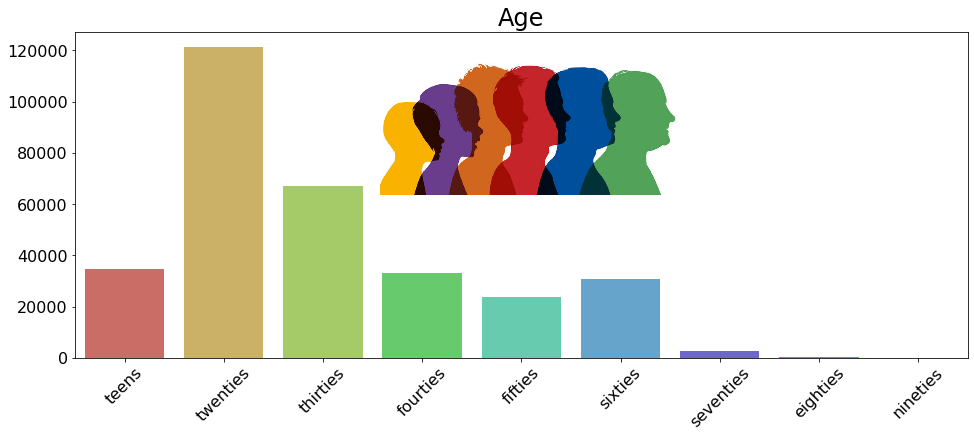

In [193]:
img_age = mpimg.imread('https://t3.ftcdn.net/jpg/01/31/28/08/\
360_F_131280894_dI65P7xcmQaIdNtBFt0gVGaP7dyXFmEj.jpg', format='jpg')

ages_order = ['teens', 'twenties', 'thirties', 'fourties', 
              'fifties', 'sixties', 'seventies', 'eighties', 'nineties']

imagebox = OffsetImage(img_age, zoom=0.42)
ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), 
                    frameon=False, pad=1, xybox=(4.1, 93000))

plt.figure(figsize=(16, 6))
ax = sns.countplot(df['age'], order=ages_order, palette='hls')
ax.add_artist(ab)

plt.title('Age', fontsize=24)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('', fontsize=14)
plt.xlabel('');

In [194]:
# Take random sample of each age
                                                  
df_age_samples = df.groupby('age').sample()

age_sorter = lambda x: x.map({
    age: order for order, age in enumerate(ages_order)
})
df_age_samples.sort_values(by='age', key=age_sorter, inplace=True)

for row in df_age_samples.itertuples():
    print(f'Age: {row.age}')
    audio_player(DATA_PATH + SAMPLES_PATH + row.path)

Age: teens


Age: twenties


Age: thirties


Age: fourties


Age: fifties


Age: sixties


Age: seventies


Age: eighties


Age: nineties


#### Gender

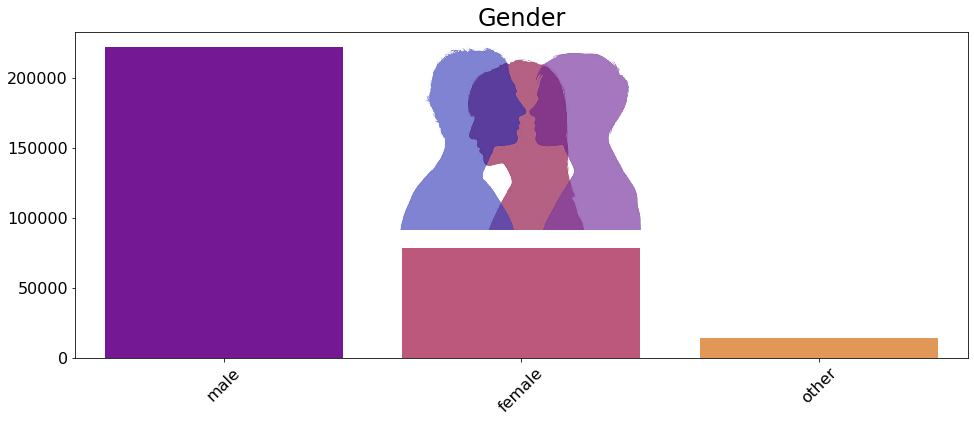

In [195]:
img_gender = mpimg.imread('https://images.newsru.co.il\
/l/60/95/609537.jpg', format='jpg')
imagebox = OffsetImage(img_gender, zoom=0.4)
ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), 
                    frameon=False, pad=1, xybox=(1, 160000))

plt.figure(figsize=(16, 6))
ax = sns.countplot(df['gender'], palette='plasma')
ax.add_artist(ab)

plt.title('Gender', fontsize=24)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('', fontsize=14)
plt.xlabel('');

In [196]:
# Take random sample of each GENDER
                                                  
df_gender_samples = df.groupby('gender').sample(random_state=42)

for row in df_gender_samples.itertuples():
    print(f'Gender: {row.gender}')
    audio_player(DATA_PATH + SAMPLES_PATH + row.path)

Gender: female


Gender: male


Gender: other


#### Unique speaker example

In [209]:
temp_cl = df['client_id'].unique()[1]
df_speaker_samples = df[df['client_id'] == temp_cl]
df_speaker_samples

client_id                          path  \
72   id_5849  common_voice_en_21788001.mp3   
73   id_5849  common_voice_en_21788002.mp3   
74   id_5849  common_voice_en_21788003.mp3   
75   id_5849  common_voice_en_21788004.mp3   

                                             sentence  up_votes  down_votes  \
72  Unfortunately, Adam overloads the computer, fr...         2           0   
73  Nepal Loktantrik Primary School is one of the ...         2           0   
74  In the same article, Gardner denied that he co...         2           0   
75  During her literary career, she has written po...         2           1   

         age gender accent  votes_disparity_rate  
72  thirties   male     us              0.398656  
73  thirties   male     us              0.398656  
74  thirties   male     us              0.398656  
75  thirties   male     us              0.087053

In [213]:
# Take each sample of the certain unique speaker
print(f'Speaker ID: {row.client_id}')
print(f'Accent    : {row.accent}')
print(f'Gender    : {row.gender}')
print(f'Age       : {row.age}\n')

for row in df_speaker_samples.itertuples():
    print(f'Sentence: {row.sentence}')
    audio_player(DATA_PATH + SAMPLES_PATH + row.path)

Speaker ID: id_5849
Accent    : us
Gender    : male
Age       : thirties

Sentence: Unfortunately, Adam overloads the computer, frying the system.


Sentence: Nepal Loktantrik Primary School is one of the schools in the district.


Sentence: In the same article, Gardner denied that he condoned pedophilia.


Sentence: During her literary career, she has written poetry, drama, tales and essays.


#### Votes

**Votes Column**:
positive and negative votes for the quality of the phrase reading

In [197]:
display(df['up_votes'].value_counts(), 
        df['down_votes'].value_counts())

2     309605
3       8884
4        582
5         59
6         28
7         23
8         22
10        21
9         17
11         6
12         5
13         1
14         1
15         1
17         1
20         1
Name: up_votes, dtype: int64

0    273132
1     45535
2       548
3        32
4         6
5         3
6         1
Name: down_votes, dtype: int64

#### Sentence
the text being read

In [198]:
df['sentence'].nunique()

319257

each sample has a unique sentence!

## Audio Data Exploration

Done with **LibROSA** — an easy-to-use library to calculate audio features.

* (`y`) — **signal**, sequence of vibrations in varying pressure strengths
* (`sr`)  —  **sample rate**, the number of samples of audio carried per second, measured in Hz

In [292]:
# Define helper func for loading audio segment
load_sound = lambda f: AudioSegment.from_file(DATA_PATH + SAMPLES_PATH + f)

Here's the audio sample which we'll explore:

In [293]:
# Take single audio sample for further exploration
eda_sample = df_speaker_samples['path'].iloc[0]

sound = load_sound(eda_sample)

print(f'File: {eda_sample}')
# Check audio sampling rate
print(f'Sample Rate: {sound.frame_rate} Hz')
# Check audio duration
print(f'Duration: {sound.duration_seconds} sec')

File: common_voice_en_21788001.mp3
Sample Rate: 48000 Hz
Duration: 6.528 sec


In [294]:
# Load signal array with librosa
y, sr = librosa.load(DATA_PATH + SAMPLES_PATH + eda_sample, sound.frame_rate)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Duration computed from len of the signal:', np.shape(y)[0] / sr)

ipd.Audio(data=y, rate=sr)

y: [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0517578e-05
 -3.0517578e-05  0.0000000e+00] 

y shape: (313344,) 

Duration computed from len of the signal: 6.528


### Sound Wave Visualization

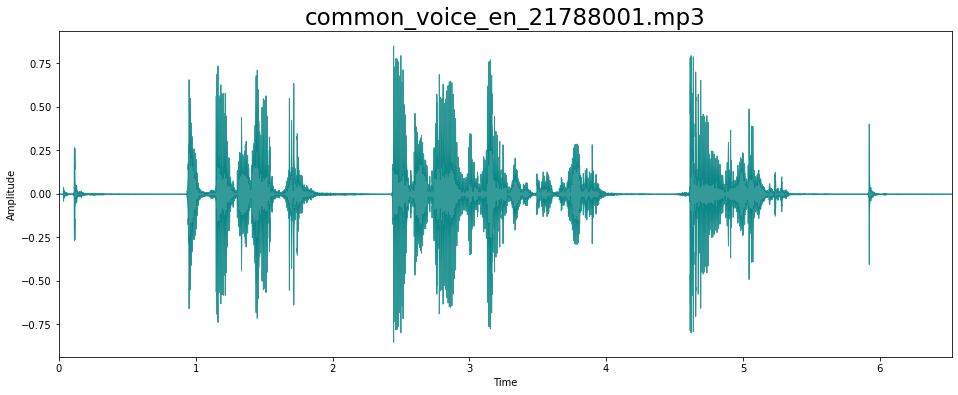

In [295]:
plt.figure(figsize = (16, 6))
plt.title(eda_sample, fontsize=23)

plt.xlabel('Time')
plt.ylabel('Amplitude')

lbd.waveplot(y, sr, alpha=0.8, color='teal');

### Fourier Transform

* Used to transform both the y-axis (frequency) to log scale, and the "color" axis (amplitude) to Decibels, which is approx. the log scale of amplitudes. This function outputs decomposition of the input signal into frequencies, allowing to find patterns of sound waves inside time-series data.

---

<center>Watch video explaning Fourier Transform in detail:</center>
<a href="https://www.youtube.com/watch?v=spUNpyF58BY" title="3Blue1Brown: But what is the Fourier Transform?"><img src="https://res.cloudinary.com/marcomontalbano/image/upload/v1620310894/video_to_markdown/images/youtube--spUNpyF58BY-c05b58ac6eb4c4700831b2b3070cd403.jpg" width="189" height="255" alt="But what is the Fourier Transform?"/>
</a>

Shape: (1025, 613)


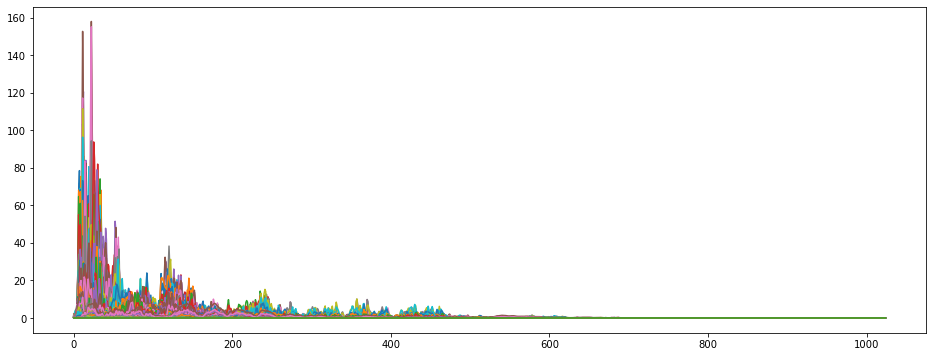

In [263]:
# Some fft parameters
n_fft = 2048  # FFT window size
hop_length = 512  # hop size

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

print('Shape:', np.shape(D))
plt.figure(figsize=(16, 6))
plt.plot(D);

### Spectrogram

* A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. 
* Wikipedia: [[>](https://en.wikipedia.org/wiki/Spectrogram)]

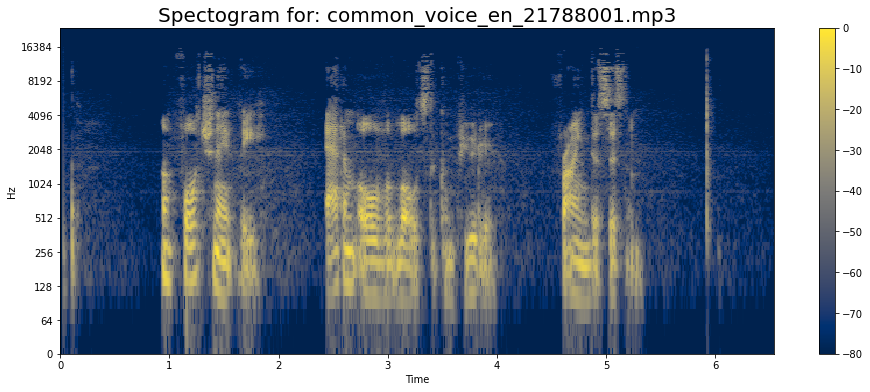

In [264]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(16, 6))
plt.title(f'Spectogram for: {eda_sample}', fontsize=20);
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='log', cmap='cividis')
plt.colorbar();

### Mel Spectrogram

* The Mel Spectrogram is a spectrogram transformed with the Mel Scale on the y axis.
* Read more: [Understanding the Mel Spectrogram](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53)

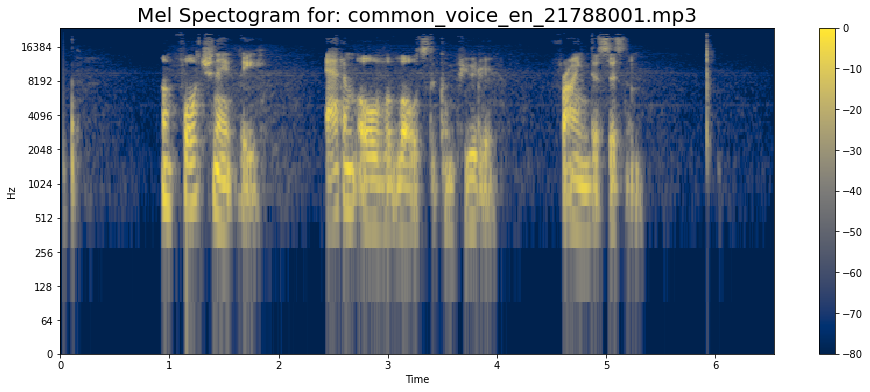

In [266]:
# Convert the Decibels-scaled spectrogram to Mel-scaled spectogram
S = librosa.feature.melspectrogram(y, sr, power=1)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
plt.title(f'Mel Spectogram for: {eda_sample}', fontsize=20);
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='log', cmap='cividis')
plt.colorbar();

## Audio Features

Now let's go through some features that can be obtained from the audio which may be valuable for the accent recognition/classification task.

### MFCC

* The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

In [296]:
# Some specific MFCC parameters
n_mfcc = 13  # number of MFCC features to extract from each sample
n_mels = 128

# Retrieve mfcc with librosa (returned shape is ([n_features], [time]))
mfcc = librosa.feature.mfcc(y, sr, 
                            n_mfcc=n_mfcc, n_mels=n_mels, 
                            n_fft=n_fft, hop_length=hop_length)

Sample duration: 6.528
MFCCs shape: (13, 613)


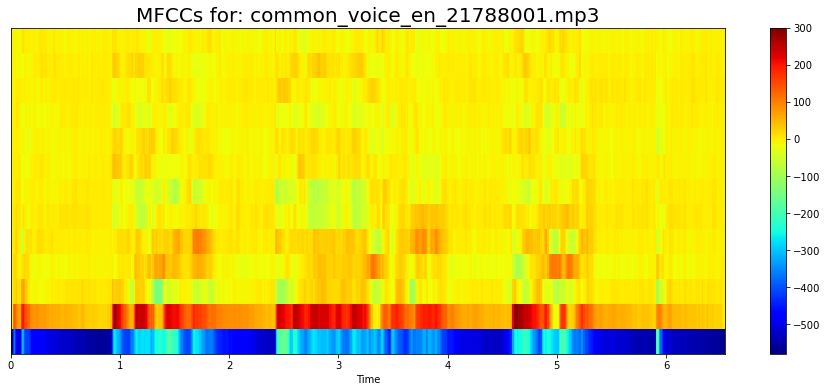

In [297]:
print('Sample duration:', sound.duration_seconds)
print('MFCCs shape:', mfcc.shape)

plt.figure(figsize = (16, 6))
plt.title(f'MFCCs for: {eda_sample}', fontsize=20)
librosa.display.specshow(mfcc,
                         sr=sr, hop_length=hop_length, 
                         x_axis='time', cmap='jet');
plt.colorbar();

### MFCC Deltas
* Deltas are dynamics characteristics of the MFCC features
* More info: [Deltas and Delta-deltas](https://wiki.aalto.fi/display/ITSP/Deltas+and+Delta-deltas)

In [298]:
delta_width = 9  # Number of frames over which to compute the delta features

# Deltas and Delta-deltas
mfcc_delta1 = librosa.feature.delta(mfcc, width=9, order=1)
mfcc_delta2 = librosa.feature.delta(mfcc, width=9, order=2)

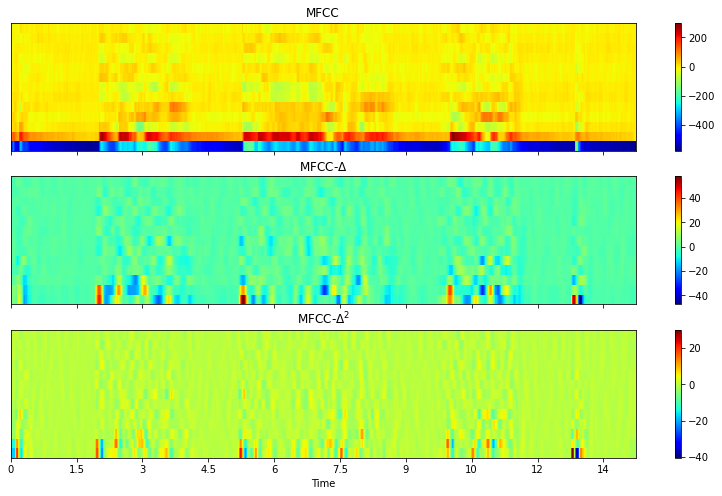

In [299]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(14, 8))

img0 = librosa.display.specshow(mfcc, ax=ax[0], x_axis='time', cmap='jet')
ax[0].set(title='MFCC')
ax[0].label_outer()
img1 = librosa.display.specshow(mfcc_delta1, ax=ax[1], x_axis='time', cmap='jet')
ax[1].set(title=r'MFCC-$\Delta$')
ax[1].label_outer()
img2 = librosa.display.specshow(mfcc_delta2, ax=ax[2], x_axis='time', cmap='jet')
ax[2].set(title=r'MFCC-$\Delta^2$')

fig.colorbar(img0, ax=[ax[0]])
fig.colorbar(img1, ax=[ax[1]])
fig.colorbar(img2, ax=[ax[2]]);

### Spectral Features (Centroid / Rolloff)

* **Spectral Rolloff** is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies

* **Spectral Centroid** indicates where the "centre of mass" for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

* Read more: [Spectral Features](https://musicinformationretrieval.com/spectral_features.html)

In [324]:
# Spectral centroid / Spectral roll-off MEANS and VARIANCES
spec_c = librosa.feature.spectral_centroid(y, sr)
spec_r = librosa.feature.spectral_rolloff(y, sr)
print(f'spectral_centroid | mean:{spec_c.mean()} var: {spec_c.var()}')
print(f'spectral_rolloff | mean:{spec_r.mean()} var: {spec_r.var()}')

spectral_centroid | mean:2637.775433640959 var: 1981885.4014006306
spectral_rolloff | mean:4922.5632137031 var: 6263753.2462206865


In [325]:
# Helper func that normalizes the signal data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Spectral Centroids shape: (613,) 



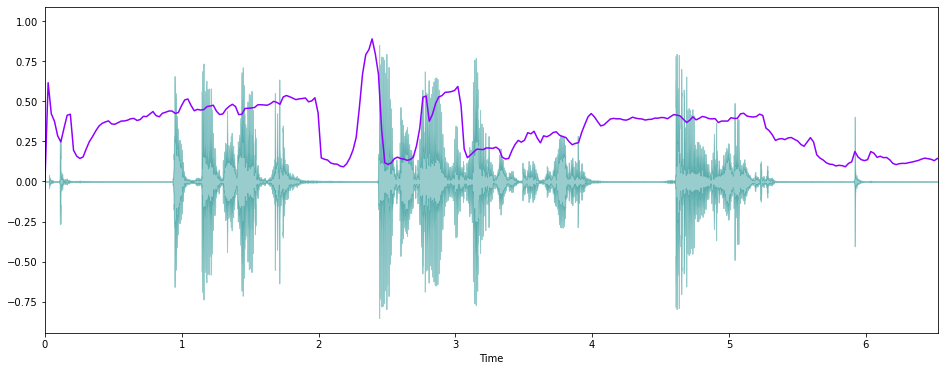

In [328]:
# Spectral Centroids vector
spectral_centroids = librosa.feature.spectral_centroid(y, sr)[0]

print('Spectral Centroids shape:', spectral_centroids.shape, '\n')

frames = range(len(spectral_centroids))  # time variable for visualization
t = librosa.frames_to_time(frames)  # convert frame counts to time in seconds

# Plot Spectral Centroid along the waveform
plt.figure(figsize=(16, 6))
lbd.waveplot(y, sr, alpha=0.4, color='teal');
plt.plot(t, normalize(spectral_centroids), color='#8F00FF');

Spectral Rolloff shape: (613,) 



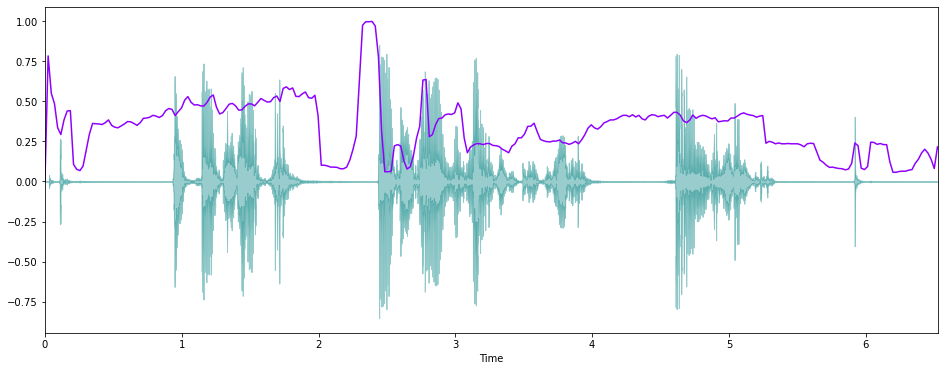

In [329]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(y, sr)[0]

print('Spectral Rolloff shape:', spectral_centroids.shape, '\n')

frames = range(len(spectral_centroids))  # time variable for visualization
t = librosa.frames_to_time(frames)  # convert frame counts to time in seconds

# Plot Spectral Rolloff along the waveform
plt.figure(figsize=(16, 6))
lbd.waveplot(y, sr, alpha=0.4, color='teal');
plt.plot(t, normalize(spectral_rolloff), color='#8F00FF');

## Sound Enhancing

Finally let's explore some possibilities to enhance sound quality by editing it

In [344]:
# Helper func to convert audiosegment signal to numpy array
npfy = lambda s: np.array(s.get_array_of_samples(), dtype=np.float64)

import array
# Helper func to convert np.array into array.array
make_arr = lambda x: array.array('h', x)

In [335]:
def read_mp3(file, sample_rate=22050, duration=None, normalized=False):
    '''Reads MP3-file to numpy array'''
    # Load mp3 file as pydub AudioSegment
    a = AudioSegment.from_mp3(file)
    # Convert to mono mode with the desired sample rate
    a = a.set_channels(1).set_frame_rate(sample_rate)
    # Normalize audio volume
    a = normalize_volume(a)
    # Trim by removing silence from beginning and end of the sound
    a = trim_silence(a)
    # Cut to the desired duration
    if duration:
        a = a[:duration * 1000]
    
    # Convert the AudioSegment to signal in form of numpy.array
    y = np.array(a.get_array_of_samples(), dtype='float')
    # Normalize if specified
    if normalized:
        y /= np.linalg.norm(y)
    return y, sample_rate

#### Normalize Volume

In [336]:
def normalize_volume(sound, target_dBFS=-20.0):
    '''Normalizes sound and shifts to specified loudness'''
    sound = sound.normalize()
    difference = target_dBFS - sound.dBFS
    return sound.apply_gain(difference)

initial sample


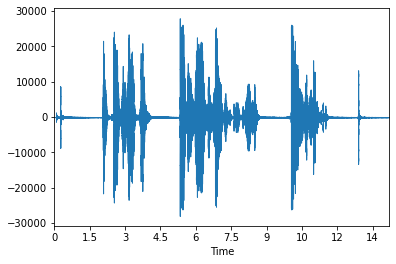

In [363]:
print('initial sample')
lbd.waveplot(npfy(sound))
sound

normalized volume


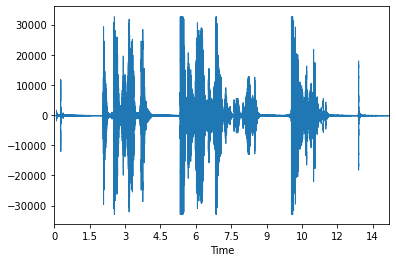

In [364]:
sound_normed = normalize_volume(sound)

print(f'normalized volume')
lbd.waveplot(npfy(sound_normed));
sound_normed

#### Trim Silence

In [410]:
def trim_silence(sound, s_thresh=-28.0):  # -34.0
    '''Trims silent chunks from beginning and end of the sound'''
    duration = len(sound)
    
    start_trim = detect_leading_silence(sound, s_thresh)
    end_trim = detect_leading_silence(sound.reverse(), s_thresh)
    
    start = start_trim if start_trim != duration else None
    end = duration - end_trim if end_trim != duration else None
    
    return sound[start:end]

initial sound shape: (313344,)
duration: 6.528 sec


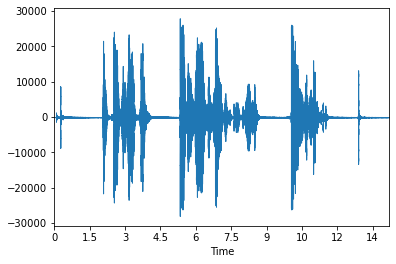

In [414]:
print('initial sound shape:', np.shape(sound.get_array_of_samples()))
print(f'duration: {sound.duration_seconds} sec')
lbd.waveplot(npfy(sound));
sound

trimmed sound shape: (279744,)
duration: 5.828 sec


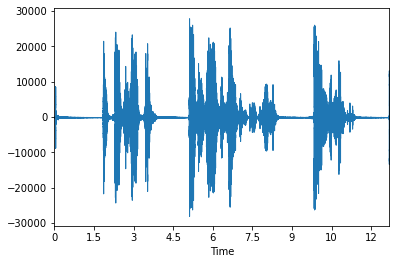

In [416]:
sound_trimmed = trim_silence(sound)

print('trimmed sound shape:', np.shape(sound_trimmed.get_array_of_samples()))
print(f'duration: {sound_trimmed.duration_seconds} sec')
lbd.waveplot(npfy(sound_trimmed));
sound_trimmed

In [418]:
for file in df[6:15]['path']:
    snd = load_sound(file)
    print(f'duration: {snd.duration_seconds} sec')
    display(file, snd)
    
    trimmed_snd = trim_silence(snd)
    print(f'trimmed duration: {trimmed_snd.duration_seconds} sec')
    display(trimmed_snd)

duration: 7.104 sec


'common_voice_en_20560595.mp3'

trimmed duration: 3.844 sec


duration: 4.704 sec


'common_voice_en_20560597.mp3'

trimmed duration: 3.044 sec


duration: 4.944 sec


'common_voice_en_20560598.mp3'

trimmed duration: 3.054 sec


duration: 3.264 sec


'common_voice_en_20560599.mp3'

trimmed duration: 1.534 sec


duration: 4.416 sec


'common_voice_en_18404206.mp3'

trimmed duration: 2.086 sec


duration: 6.576 sec


'common_voice_en_18404207.mp3'

trimmed duration: 3.976 sec


duration: 5.832 sec


'common_voice_en_18404209.mp3'

trimmed duration: 3.262 sec


duration: 9.336 sec


'common_voice_en_19966428.mp3'

trimmed duration: 7.306 sec


duration: 3.36 sec


'common_voice_en_19966430.mp3'

trimmed duration: 1.81 sec


#### Reduce Noise

common_voice_en_19966428.mp3


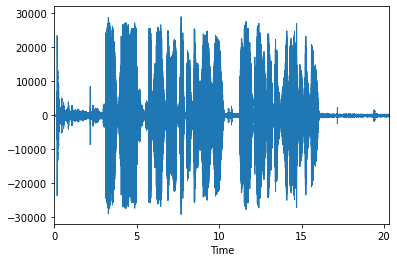

In [446]:
file = df.iloc[13]['path']
snd = load_sound(file)

print(file)
display(snd)
lbd.waveplot(npfy(snd));

In [426]:
import noisereduce as nr

In [432]:
from pydub import silence

In [488]:
# https://github.com/jiaaro/pydub/blob/master/pydub/silence.py

def get_silence(sound):
    '''Returns the longest chunk of silence detected'''
    silence_chunks = silence.detect_silence(sound, 
                                            min_silence_len=60, 
                                            silence_thresh=-36)
    
    durations = [(ch, ch[1] - ch[0]) for ch in silence_chunks]  # make list of chunks durations
    lchunk = max(durations, key=lambda x: x[1])[0]  # determine the longest chunk
    return sound[lchunk[0]:lchunk[1]]
    

%timeit get_silence(sound)

92.6 ms ± 5.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [489]:
def denoise(sound, noisy_part=None):
    '''Performs denoising of the given AudioSegment'''
    if not noisy_part:
        noisy_part = get_silence(sound)  # select section of data that is noise
        
    reduced_noise = nr.reduce_noise(audio_clip=npfy(sound),  # perform noise reduction
                                    noise_clip=npfy(noisy_part))
    denoised_samples = make_arr(reduced_noise.round().astype(np.float32))
    return sound._spawn(denoised_samples)

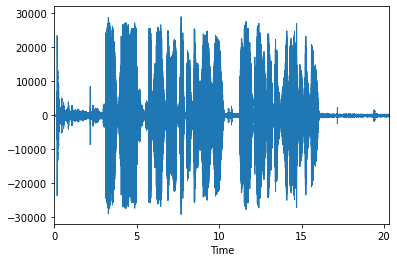

In [490]:
display(snd)
lbd.waveplot(npfy(snd));

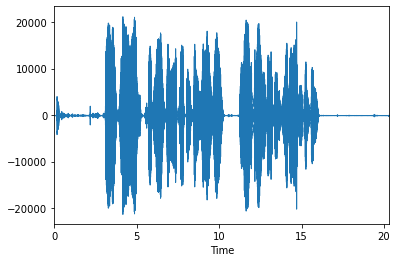

In [491]:
snd_denoised = denoise(snd, snd[:200])

display(snd_denoised)
lbd.waveplot(npfy(snd_denoised));

In [492]:
%%timeit
denoise(snd)

1.47 s ± 47.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**[ ! ]** It can be seen that the task of denoising is very resource-intensive

common_voice_en_19966428.mp3

trimmed:


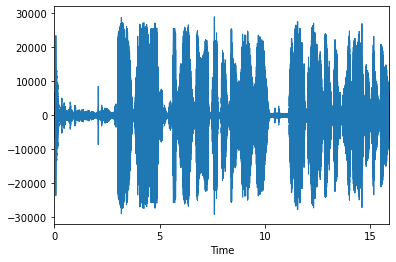

In [496]:
snd_trimmed = trim_silence(snd)

print(file)
print('\ntrimmed:')
display(snd_trimmed)
lbd.waveplot(npfy(snd_trimmed));

common_voice_en_19966428.mp3

denoised:


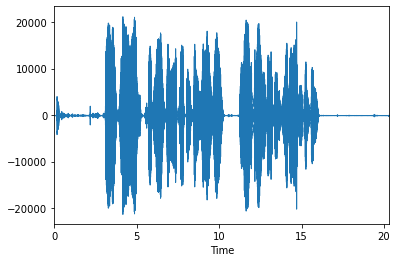

In [497]:
snd_denoised = denoise(snd, snd[:200])

print(file)
print('\ndenoised:')
display(snd_denoised)
lbd.waveplot(npfy(snd_denoised));

common_voice_en_19966428.mp3

denoised + trimmed:


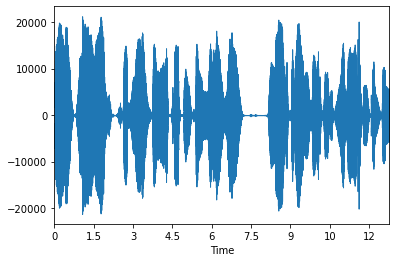

In [506]:
snd_denoised_trimmed = trim_silence(snd_denoised, s_thresh=-22.0)

print(file)
print('\ndenoised + trimmed:')
display(snd_denoised_trimmed)
lbd.waveplot(npfy(snd_denoised_trimmed));